#Imports & Notes:

In [11]:
# Name: Pavitra Patel

import random
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

#Task 1:

In [2]:
# This class contains complete setup/algorithm for both logic bot and model/network bot to play a game
class MineSweeper_Bots:
    def __init__(self, rows, cols, num_of_mines, allow_mines, allow_print):
        self.rows = rows
        self.cols = cols
        self.num_of_mines = num_of_mines
        self.allow_mines = allow_mines
        self.allow_print = allow_print
        self.adj_directions = [(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1)]
        self.reset()

    def reset(self):
        """
        Reset or initialize the board at the start of a new game. This method sets up the board, mines,
        and other game variables to their starting state.
        """
        self.board = [['#' for _ in range(self.cols)] for _ in range(self.rows)]
        self.cells_remaining = set((i, j) for i in range(self.rows) for j in range(self.cols))
        self.inferred_safe = set()
        self.inferred_mine = set()
        self.clue_number = {}
        self.revealed_cells = set()
        self.mines_triggered = set()

        self.input_states = []
        self.output_states = []

        # Select the initial safe cell randomly and set it up without a mine
        r, c = random.randint(0, self.rows - 1), random.randint(0, self.cols - 1)
        self.initial_safe_cell(r, c)

    def initial_safe_cell(self, r, c):
        """
        Set up the initial safe cell and its neighbors. The selected cell and its neighbors are cleared
        of mines and marked safe.
        :param r: Row index of the initially selected safe cell.
        :param c: Column index of the initially selected safe cell.
        """
        self.board[r][c] = '0'  # Set the clue of the initial cell to 0, indicating no adjacent mines
        self.cells_remaining.remove((r, c))
        self.revealed_cells.add((r, c))
        self.clue_number[(r, c)] = 0

        valid_neighbors = self.get_neighbors((r, c))
        self.inferred_safe.update(valid_neighbors)
        for nei in valid_neighbors:
            self.cells_remaining.remove(nei)

        # Print the initial board setup if allowed
        if self.allow_print:
            self.print_board()

        # Exclude the initial safe cell and its neighbors from being potential mine locations
        possible_mine_locations = list(self.cells_remaining - self.inferred_safe)
        self.mines = set(random.sample(possible_mine_locations, self.num_of_mines))

    def get_neighbors(self, cell):
        """
        Get all valid neighboring cells of a given cell.
        :param cell: A tuple (r, c) representing the cell for which neighbors are to be found.
        :return: A set of tuples representing the valid neighbors of the given cell.
        """
        r, c = cell
        return {(r + dr, c + dc) for dr, dc in self.adj_directions if 0 <= r + dr < self.rows and 0 <= c + dc < self.cols}

    def print_board(self):
        """
        Print the current state of the minesweeper board.
        """
        for row in self.board:
            print(' '.join(str(cell) for cell in row))
        print()

    def reveal_clue(self, reveal_cell):
        valid_neighbors = self.get_neighbors(reveal_cell)
        return sum(1 for nei in valid_neighbors if nei in self.mines)

    def play(self):
        while True:
            if (self.rows*self.cols)-self.num_of_mines == len(self.revealed_cells):
                return len(self.revealed_cells), len(self.mines_triggered), self.input_states, self.output_states

            if self.inferred_safe:
                reveal_cell = self.inferred_safe.pop()
            else:
                reveal_cell = self.cells_remaining.pop()

            if reveal_cell in self.mines:
                self.mines_triggered.add(reveal_cell)
                r_m, c_m = reveal_cell
                self.board[r_m][c_m] = 'M'
                if not self.allow_mines:
                    if self.allow_print:
                        self.print_board()
                    self.generate_data()
                    return len(self.revealed_cells), len(self.mines_triggered), self.input_states, self.output_states
            else:
                self.revealed_cells.add(reveal_cell)
                reveal_cell_clue = self.reveal_clue(reveal_cell)
                self.clue_number[reveal_cell] = reveal_cell_clue
                r, c = reveal_cell
                self.board[r][c] = str(reveal_cell_clue)

            if self.allow_print:
                self.print_board()
            self.generate_data()

            for cell, clue in self.clue_number.items():
                valid_neighbors = self.get_neighbors(cell)
                num_nei_inferred_mines = sum(1 for nei in valid_neighbors if nei in self.inferred_mine)
                num_unrevealed_nei = sum(1 for nei in valid_neighbors if nei not in self.revealed_cells)

                if (clue - num_nei_inferred_mines) == num_unrevealed_nei:
                    for nei in valid_neighbors:
                        if nei not in self.revealed_cells:
                            self.inferred_mine.add(nei)
                            # self.cells_remaining.remove(nei)
                            self.cells_remaining.discard(nei)

                num_nei_revealed_or_inferred_safe = 0
                for nei in valid_neighbors:
                    if nei in self.revealed_cells or nei in self.inferred_safe:
                        num_nei_revealed_or_inferred_safe += 1

                if (len(valid_neighbors) - clue) - num_nei_revealed_or_inferred_safe == num_unrevealed_nei:
                    for nei in valid_neighbors:
                        if nei not in self.revealed_cells:
                            self.inferred_safe.add(nei)
                            self.cells_remaining.remove(nei)

    def generate_data(self):
        # Input: Convert self.board -> For clue #: 0 to 8, For Unclicked: 9, For Mine: 10
        # Output: Convert self.board -> For Mine: 0, For Safe: 1
        temp_i = copy.deepcopy(self.board)
        for i, row in enumerate(self.board):
            for j, element in enumerate(row):
                if element == 'M':
                    num = 10
                elif element == '#':
                    num = 9
                else:
                    num = int(element)
                temp_i[i][j] = num
        self.input_states.append(temp_i)

        temp_o = copy.deepcopy(self.board)
        for i, row in enumerate(self.board):
            for j, element in enumerate(row):
                temp_o[i][j] = 0 if (i, j) in self.mines else 1
        self.output_states.append(temp_o)

    def model_play(self, model, embeddings):
        model.eval()
        for cell in self.inferred_safe:
            self.cells_remaining.add(cell)
        while self.inferred_safe:
            self.inferred_safe.pop()

        while True:
            if (self.rows * self.cols - self.num_of_mines) == len(self.revealed_cells):
                return len(self.revealed_cells), len(self.mines_triggered), self.input_states, self.output_states

            c_s = [[9 if cell == '#' else (10 if cell == 'M' else int(cell)) for cell in row] for row in self.board]
            current_state = torch.tensor(c_s, dtype=torch.long)
            embedded_input = embeddings(current_state).unsqueeze(0)  # Add batch dimension
            board_tensor = embedded_input.permute(0, 3, 1, 2)  # Rearrange to [batch, channels, height, width]

            # Predict the safest cell to reveal next
            with torch.no_grad():
                predictions = model(board_tensor).squeeze(0)  # Remove batch dimension

            # Choose the cell with the highest safety score
            max_prob = 0
            cell_to_reveal = None
            for r in range(self.rows):
                for c in range(self.cols):
                    if (r, c) in self.cells_remaining and predictions[r][c] > max_prob:
                        max_prob = predictions[r][c]
                        cell_to_reveal = (r, c)
            if self.allow_print:
                print(f"Clicking: {cell_to_reveal}")

            if cell_to_reveal in self.mines:
                self.mines_triggered.add(cell_to_reveal)
                r, c = cell_to_reveal
                self.board[r][c] = 'M'
                if not self.allow_mines:
                    if self.allow_print:
                        self.print_board()
                    self.generate_data()
                    return len(self.revealed_cells), len(self.mines_triggered), self.input_states, self.output_states
            else:
                r, c = cell_to_reveal
                self.revealed_cells.add(cell_to_reveal)
                clue = self.reveal_clue(cell_to_reveal)
                self.board[r][c] = str(clue)

            self.cells_remaining.remove(cell_to_reveal)

            if self.allow_print:
                self.print_board()
            self.generate_data()

In [12]:
# This method is meant for easy reuse combining many functionalities
# rows -> rows in a board
# cols -> columns in a board
# num_of_mines -> number of mines on a board
# allow_mines -> when set to True, the game is allowed to continue after a mine is triggered until the last safe cell is explored
# allow_board_print -> prints the game played
# num_game_play -> number of games to play
# flag_logic_bot -> game is played by logic bot when set to true
# model, embeddings -> when flag_logic_bot is False and model, embeddings is passed, the game is played by model/network bot
# The method also returns detailed stats of games played

def run_bot_and_get_stats(rows, cols, num_of_mines, allow_mines, allow_board_print, num_game_play, flag_logic_bot, model, embeddings):
    won = 0
    cells_opened_list = []
    mines_triggered_list = []

    input_states = []
    output_states = []

    for i in range(num_game_play):
        print(i)
        bot = MineSweeper_Bots(rows, cols, num_of_mines, allow_mines, allow_board_print)
        if flag_logic_bot:
            num_cells_opened, num_mines_triggered, i_states, o_states = bot.play()
        else:
            num_cells_opened, num_mines_triggered, i_states, o_states = bot.model_play(model, embeddings)
        if num_cells_opened == ((rows * cols) - num_of_mines) and num_mines_triggered == 0:
            won += 1
        cells_opened_list.append(num_cells_opened)
        mines_triggered_list.append(num_mines_triggered)
        input_states.extend(i_states)
        output_states.extend(o_states)

    # Calculating averages
    avg_cells_opened = np.mean(cells_opened_list)
    avg_mines_triggered = np.mean(mines_triggered_list)

    # Calculating variances
    var_cells_opened = np.var(cells_opened_list)
    var_mines_triggered = np.var(mines_triggered_list)

    print(f"Count Bot Won: {won}")
    print(f"Avg. Cells Opened: {avg_cells_opened}, Variance: {var_cells_opened}")
    print(f"Avg. Mines Triggered: {avg_mines_triggered}, Variance: {var_mines_triggered}")
    print(f"Data Points Generated: {len(input_states)}")

    return input_states, output_states, won, avg_cells_opened, avg_mines_triggered, var_cells_opened, var_mines_triggered

#Task 1: Easy Level

In [7]:
# This code approximately takes 4 mins to run on ilab2 cpu

# Generate Train Dataset (Approx. 80%)
print("Generating Train Dataset ... ")
print("Phase 1/2: Ending game after a mine is triggered")
input_states_train1, output_states_train1, _, _, _, _, _ = run_bot_and_get_stats(9, 9, 10, False, False, 4000, True, None, None)
print()
print("Phase 2/2: Continuing game after a mine is triggered")
input_states_train2, output_states_train2, _, _, _, _, _ = run_bot_and_get_stats(9, 9, 10, True, False, 4000, True, None, None)

input_states_train = input_states_train1 + input_states_train2
output_states_train = output_states_train1 + output_states_train2


# Generate Test Dataset (Approx. 20%)
print("Generating Test Dataset ... ")
print("Phase 1/2: Ending game after a mine is triggered")
input_states_test1, output_states_test1, _, _, _, _, _ = run_bot_and_get_stats(9, 9, 10, False, False, 1000, True, None, None)
print()
print("Phase 2/2: Continuing game after a mine is triggered")
input_states_test2, output_states_test2, _, _, _, _, _ = run_bot_and_get_stats(9, 9, 10, True, False, 1000, True, None, None)

input_states_test = input_states_test1 + input_states_test2
output_states_test = output_states_test1 + output_states_test2

tensor_x_train = torch.Tensor(input_states_train)
tensor_y_train = torch.Tensor(output_states_train)
train_dataset = TensorDataset(tensor_x_train, tensor_y_train)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)

tensor_x_test = torch.Tensor(input_states_test)
tensor_y_test = torch.Tensor(output_states_test)
test_dataset = TensorDataset(tensor_x_test, tensor_y_test)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)

Generating Train Dataset ... 
Phase 1/2: Ending game after a mine is triggered
Count Bot Won: 148
Avg. Cells Opened: 50.10425, Variance: 225.23338193750004
Avg. Mines Triggered: 0.963, Variance: 0.03563099999999999
Data Points Generated: 200269

Phase 2/2: Continuing game after a mine is triggered
Count Bot Won: 134
Avg. Cells Opened: 71.0, Variance: 0.0
Avg. Mines Triggered: 3.0295, Variance: 2.1726297499999996
Data Points Generated: 292118
Generating Test Dataset ... 
Phase 1/2: Ending game after a mine is triggered
Count Bot Won: 28
Avg. Cells Opened: 50.137, Variance: 230.00623099999996
Avg. Mines Triggered: 0.972, Variance: 0.027215999999999997
Data Points Generated: 50109

Phase 2/2: Continuing game after a mine is triggered
Count Bot Won: 33
Avg. Cells Opened: 71.0, Variance: 0.0
Avg. Mines Triggered: 2.955, Variance: 2.196975
Data Points Generated: 72955


In [13]:
embedding_dim = 3
num_of_embeddings = 11
embeddings = nn.Embedding(num_of_embeddings, embedding_dim)

class Minesweeper_Model_Easy(nn.Module):
    def __init__(self, embedding_dim):
        super(Minesweeper_Model_Easy, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=embedding_dim, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.fc1 = nn.Linear(9 * 9 * 256, 9 * 9)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = torch.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = torch.relu(x)
        x = self.conv4(x)
        x = self.bn4(x)
        x = torch.relu(x)
        x = x.reshape(x.size(0), -1)
        x = torch.sigmoid(self.fc1(x))
        return x.reshape(-1, 9, 9)

def get_output(embeddings, model, x):
    x = embeddings(x)
    x = x.permute(0, 3, 1, 2)
    return model(x)

In [14]:
# Initialize model
model_easy = Minesweeper_Model_Easy(embedding_dim)
print(model_easy)
print()
# Calculate and print the total number of parameters
total_params = sum(p.numel() for p in model_easy.parameters())
print("Total number of parameters: ", total_params)

# Define optimizers
model_easy_optimizer = torch.optim.SGD(model_easy.parameters(), lr=0.01)

criterion = nn.BCELoss()

Minesweeper_Model_Easy(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=20736, out_features=81, bias=True)
)

Total number of parameters:  2069073


In [15]:
train_losses = []
test_losses = []

def train_and_test(model, embeddings, train_dataloader, test_dataloader, model_optimizer, criterion, epochs):
    for epoch in range(epochs):
        # Set model to training mode
        model.train()

        # Only the model parameters are trainable
        optimizer = model_optimizer

        # Training phase
        total_train_loss = 0
        for inputs, targets in train_dataloader:
            inputs, targets = inputs.long(), targets.float()  # Correct data types
            optimizer.zero_grad()
            outputs = get_output(embeddings, model, inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)  # Store train loss for plotting

        # Testing phase
        model.eval()  # Set model to evaluation mode
        total_test_loss = 0
        with torch.no_grad():
            for inputs, targets in test_dataloader:
                inputs, targets = inputs.long(), targets.float()
                outputs = get_output(embeddings, model, inputs)
                loss = criterion(outputs, targets)
                total_test_loss += loss.item()

        avg_test_loss = total_test_loss / len(test_dataloader)
        test_losses.append(avg_test_loss)  # Store test loss for plotting

        # Print average losses after each epoch
        print(f'Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Test Loss = {avg_test_loss:.4f}')

In [12]:
# This code approximately takes 45 mins to train on ilab2 cpu
train_and_test(model_easy, embeddings, train_dataloader, test_dataloader, model_easy_optimizer, criterion, 10)

Epoch 1: Train Loss = 0.2892, Test Loss = 0.2503
Epoch 2: Train Loss = 0.2263, Test Loss = 0.2250
Epoch 3: Train Loss = 0.2061, Test Loss = 0.2123
Epoch 4: Train Loss = 0.1938, Test Loss = 0.2041
Epoch 5: Train Loss = 0.1854, Test Loss = 0.1988
Epoch 6: Train Loss = 0.1793, Test Loss = 0.1951
Epoch 7: Train Loss = 0.1746, Test Loss = 0.1925
Epoch 8: Train Loss = 0.1708, Test Loss = 0.1908
Epoch 9: Train Loss = 0.1676, Test Loss = 0.1896
Epoch 10: Train Loss = 0.1649, Test Loss = 0.1888


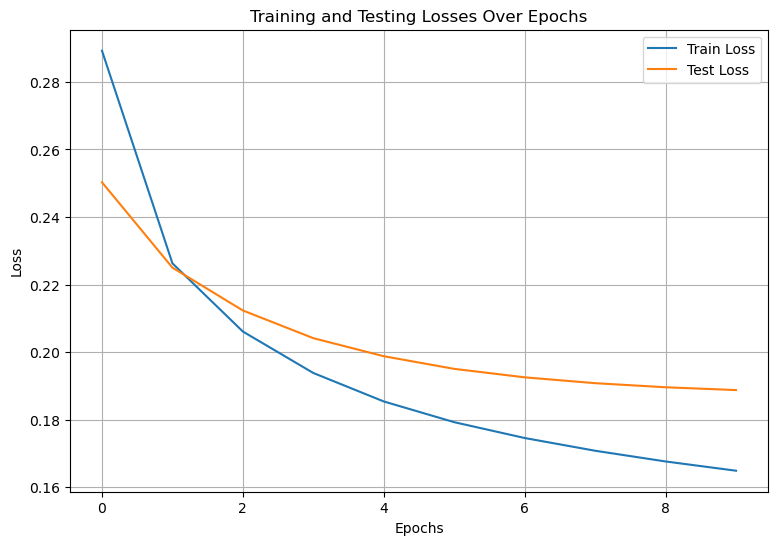

In [13]:
# Plot training and testing losses
plt.figure(figsize=(9, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Training and Testing Losses Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [63]:
# Save the model
torch.save(model_easy, 'model_easy_1.pth')

# Save the embeddings
embeddings_weights = embeddings.weight.data
torch.save(embeddings_weights, 'embeddings_easy_1.pth')

In [7]:
# Load the model
model_easy = torch.load('model_easy_1.pth')
model_easy.eval()

# Load the embeddings
loaded_embeddings_tensor = torch.load('embeddings_easy_1.pth')
num_embeddings, embedding_dim = loaded_embeddings_tensor.size(0), loaded_embeddings_tensor.size(1)
embeddings = nn.Embedding(num_embeddings, embedding_dim)
embeddings.weight.data.copy_(loaded_embeddings_tensor)
embeddings.weight.requires_grad = False

In [54]:
# This code approximately takes 2 mins to run on ilab2 cpu
# Logic Bot Performance on Easy Level - Game ends after a mine is triggered
_, _, won_e1, avg_cells_opened_e1, avg_mines_triggered_e1, var_cells_opened_e1, var_mines_triggered_e1 = run_bot_and_get_stats(9, 9, 10, False, False, 8000, True, None, None)

Count Bot Won: 255
Avg. Cells Opened: 49.960875, Variance: 227.842344234375
Avg. Mines Triggered: 0.968125, Variance: 0.030858984375
Data Points Generated: 399432


In [55]:
# This code approximately takes 18 mins to run on ilab2 cpu
# Model Performance on Easy Level - Game ends after a mine is triggered
_, _, won_e2, avg_cells_opened_e2, avg_mines_triggered_e2, var_cells_opened_e2, var_mines_triggered_e2 = run_bot_and_get_stats(9, 9, 10, False, False, 8000, False, model_easy, embeddings)

Count Bot Won: 1696
Avg. Cells Opened: 61.26825, Variance: 198.52629193750002
Avg. Mines Triggered: 0.788, Variance: 0.16705600000000004
Data Points Generated: 488450


In [67]:
# This code approximately takes 3 mins to run on ilab2 cpu
# Logic Bot Performance on Easy Level - Game ends only after all safe cells have been discovered, allowed to continue afte a mine is triggered
_, _, won_e3, avg_cells_opened_e3, avg_mines_triggered_e3, var_cells_opened_e3, var_mines_triggered_e3 = run_bot_and_get_stats(9, 9, 10, True, False, 8000, True, None, None)

Count Bot Won: 255
Avg. Cells Opened: 71.0, Variance: 0.0
Avg. Mines Triggered: 3.030625, Variance: 2.220437109375
Data Points Generated: 584245


In [1]:
# This code approximately takes 30 mins to run on ilab2 cpu
# Model Performance on Easy Level - Game ends only after all safe cells have been discovered, allowed to continue afte a mine is triggered
_, _, won_e4, avg_cells_opened_e4, avg_mines_triggered_e4, var_cells_opened_e4, var_mines_triggered_e4 = run_bot_and_get_stats(9, 9, 10, True, False, 8000, False, model_easy, embeddings)

Count Bot Won: 1679
Avg. Cells Opened: 71.0, Variance: 0.0
Avg. Mines Triggered: 1.65025, Variance: 1.9026749375000003
Data Points Generated: 573202


#Task 1: Intermediate Level

In [1]:
# This code approximately takes 18 mins to run on ilab2 gpu
# Generate Train Dataset (Approx. 80%)
print("Generating Train Dataset ... ")
print("Phase 1/2: Ending game after a mine is triggered")
input_states_train1, output_states_train1, _, _, _, _, _ = run_bot_and_get_stats(16, 16, 40, False, False, 3000, True, None, None)
print()
print("Phase 2/2: Continuing game after a mine is triggered")
input_states_train2, output_states_train2, _, _, _, _, _ = run_bot_and_get_stats(16, 16, 40, True, False, 3000, True, None, None)
print()

input_states_train = input_states_train1 + input_states_train2
output_states_train = output_states_train1 + output_states_train2


# Generate Test Dataset (Approx. 20%)
print("Generating Test Dataset ... ")
print("Phase 1/2: Ending game after a mine is triggered")
input_states_test1, output_states_test1, _, _, _, _, _ = run_bot_and_get_stats(16, 16, 40, False, False, 750, True, None, None)
print()
print("Phase 2/2: Continuing game after a mine is triggered")
input_states_test2, output_states_test2, _, _, _, _, _ = run_bot_and_get_stats(16, 16, 40, True, False, 750, True, None, None)

input_states_test = input_states_test1 + input_states_test2
output_states_test = output_states_test1 + output_states_test2

tensor_x_train = torch.Tensor(input_states_train)
tensor_y_train = torch.Tensor(output_states_train)
train_dataset = TensorDataset(tensor_x_train, tensor_y_train)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)

tensor_x_test = torch.Tensor(input_states_test)
tensor_y_test = torch.Tensor(output_states_test)
test_dataset = TensorDataset(tensor_x_test, tensor_y_test)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)

Generating Train Dataset ... 
Phase 1/2: Ending game after a mine is triggered
Count Bot Won: 0
Avg. Cells Opened: 79.5702, Variance: 1671.0446719600002
Avg. Mines Triggered: 1.0, Variance: 0.0
Data Points Generated: 397851

Phase 2/2: Continuing game after a mine is triggered
Count Bot Won: 0
Avg. Cells Opened: 216.0, Variance: 0.0
Avg. Mines Triggered: 16.4608, Variance: 11.12846336
Data Points Generated: 1157304

Generating Test Dataset ... 
Phase 1/2: Ending game after a mine is triggered
Count Bot Won: 0
Avg. Cells Opened: 80.48, Variance: 1717.0816
Avg. Mines Triggered: 1.0, Variance: 0.0
Data Points Generated: 100600

Phase 2/2: Continuing game after a mine is triggered
Count Bot Won: 0
Avg. Cells Opened: 216.0, Variance: 0.0
Avg. Mines Triggered: 16.4408, Variance: 11.516895360000001
Data Points Generated: 289301


In [7]:
num_of_embeddings = 11
embedding_dim = 3
embeddings = nn.Embedding(num_of_embeddings, embedding_dim)

def get_output(embeddings, model, x):
    x = embeddings(x)
    x = x.permute(0, 3, 1, 2)
    return model(x)

class Minesweeper_Model_Medium(nn.Module):
    def __init__(self):
        super(Minesweeper_Model_Medium, self).__init__()
        self.conv1 = nn.Conv2d(embedding_dim, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.dropout1 = nn.Dropout(p=0.3)
        self.fc1 = nn.Linear(128 * 16 * 16, 16 * 16)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.dropout1(x)
        x = x.reshape(-1, 128 * 16 * 16)
        x = torch.sigmoid(self.fc1(x))
        return x.view(-1, 16, 16)

model_medium = Minesweeper_Model_Medium()
model_medium_optimizer = torch.optim.SGD(model_medium.parameters(), lr=0.01, weight_decay=1e-3)
criterion = nn.BCELoss()

print(model_medium)
print()
total_params = sum(p.numel() for p in model_medium.parameters())
print("Total number of parameters: ", total_params)

Minesweeper_Model_Medium(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=32768, out_features=256, bias=True)
)

Total number of parameters:  8482560


In [8]:
# This code approximately takes 98 mins to run on ilab2 gpu
train_losses = []
test_losses = []
train_and_test(model_medium, embeddings, train_dataloader, test_dataloader, model_medium_optimizer, criterion, 10)

Epoch 1: Train Loss = 0.3829, Test Loss = 0.3521
Epoch 2: Train Loss = 0.3041, Test Loss = 0.3140
Epoch 3: Train Loss = 0.2698, Test Loss = 0.2933
Epoch 4: Train Loss = 0.2504, Test Loss = 0.2813
Epoch 5: Train Loss = 0.2382, Test Loss = 0.2735
Epoch 6: Train Loss = 0.2299, Test Loss = 0.2691
Epoch 7: Train Loss = 0.2240, Test Loss = 0.2653
Epoch 8: Train Loss = 0.2196, Test Loss = 0.2631
Epoch 9: Train Loss = 0.2160, Test Loss = 0.2610
Epoch 10: Train Loss = 0.2131, Test Loss = 0.2597


In [ ]:
# Save the model
torch.save(model_medium, 'model_medium_1.pth')

# Save the embeddings
embeddings_weights = embeddings.weight.data
torch.save(embeddings_weights, 'embeddings_med_1.pth')

In [ ]:
# Load the model
model_medium = torch.load('model_medium_1.pth')
model_medium.eval()

# Load the embeddings
loaded_embeddings_tensor = torch.load('embeddings_med_1.pth')
num_embeddings, embedding_dim = loaded_embeddings_tensor.size(0), loaded_embeddings_tensor.size(1)
embeddings = nn.Embedding(num_embeddings, embedding_dim)
embeddings.weight.data.copy_(loaded_embeddings_tensor)
embeddings.weight.requires_grad = False

In [10]:
# This code approximately takes 38 mins to run on ilab2 gpu
_, _, _, _, _, _, _ = run_bot_and_get_stats(16, 16, 40, False, False, 1000, False, model_medium, embeddings)
print()
_, _, _, _, _, _, _ = run_bot_and_get_stats(16, 16, 40, True, False, 1000, False, model_medium, embeddings)

Count Bot Won: 0
Avg. Cells Opened: 80.538, Variance: 1620.846556
Avg. Mines Triggered: 1.0, Variance: 0.0
Data Points Generated: 80538

Count Bot Won: 0
Avg. Cells Opened: 216.0, Variance: 0.0
Avg. Mines Triggered: 14.475, Variance: 25.475375
Data Points Generated: 229475


In [11]:
# This code approximately takes 18 mins to run on ilab2 gpu
# Generate Train Dataset (Approx. 80%)
print("Generating Train Dataset ... ")
print("Phase 1/2: Ending game after a mine is triggered")
input_states_train1, output_states_train1, _, _, _, _, _ = run_bot_and_get_stats(16, 16, 40, False, False, 3000, True, None, None)
print()
print("Phase 2/2: Continuing game after a mine is triggered")
input_states_train2, output_states_train2, _, _, _, _, _ = run_bot_and_get_stats(16, 16, 40, True, False, 3000, True, None, None)
print()

input_states_train = input_states_train1 + input_states_train2
output_states_train = output_states_train1 + output_states_train2

# Generate Test Dataset (Approx. 20%)
print("Generating Test Dataset ... ")
print("Phase 1/2: Ending game after a mine is triggered")
input_states_test1, output_states_test1, _, _, _, _, _ = run_bot_and_get_stats(16, 16, 40, False, False, 750, True, None, None)
print()
print("Phase 2/2: Continuing game after a mine is triggered")
input_states_test2, output_states_test2, _, _, _, _, _ = run_bot_and_get_stats(16, 16, 40, True, False, 750, True, None, None)

input_states_test = input_states_test1 + input_states_test2
output_states_test = output_states_test1 + output_states_test2

tensor_x_train = torch.Tensor(input_states_train)
tensor_y_train = torch.Tensor(output_states_train)
train_dataset = TensorDataset(tensor_x_train, tensor_y_train)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)

tensor_x_test = torch.Tensor(input_states_test)
tensor_y_test = torch.Tensor(output_states_test)
test_dataset = TensorDataset(tensor_x_test, tensor_y_test)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)

Generating Train Dataset ... 
Phase 1/2: Ending game after a mine is triggered
Count Bot Won: 0
Avg. Cells Opened: 78.97133333333333, Variance: 1683.9491782222221
Avg. Mines Triggered: 1.0, Variance: 0.0
Data Points Generated: 236914

Phase 2/2: Continuing game after a mine is triggered
Count Bot Won: 0
Avg. Cells Opened: 216.0, Variance: 0.0
Avg. Mines Triggered: 16.527, Variance: 11.459937666666665
Data Points Generated: 694581

Generating Test Dataset ... 
Phase 1/2: Ending game after a mine is triggered
Count Bot Won: 0
Avg. Cells Opened: 80.03733333333334, Variance: 1683.6359395555555
Avg. Mines Triggered: 1.0, Variance: 0.0
Data Points Generated: 60028

Phase 2/2: Continuing game after a mine is triggered
Count Bot Won: 0
Avg. Cells Opened: 216.0, Variance: 0.0
Avg. Mines Triggered: 16.417333333333332, Variance: 11.512499555555555
Data Points Generated: 173563


In [12]:
# This code approximatley takes 18 mins to run on ilab2 gpu
train_and_test(model_medium, embeddings, train_dataloader, test_dataloader, model_medium_optimizer, criterion, 2)

Epoch 1: Train Loss = 0.2618, Test Loss = 0.2605
Epoch 2: Train Loss = 0.2618, Test Loss = 0.2603


In [ ]:
# Save the model
torch.save(model_medium, 'model_medium_2.pth')

In [ ]:
# Load the model
model_medium = torch.load('model_medium_2.pth')
model_medium.eval()

In [15]:
# This code approximately takes 38 mins to run on ilab2 gpu
_, _, _, _, _, _, _ = run_bot_and_get_stats(16, 16, 40, False, False, 1000, False, model_medium, embeddings)
print()
_, _, _, _, _, _, _ = run_bot_and_get_stats(16, 16, 40, True, False, 1000, False, model_medium, embeddings)

Count Bot Won: 0
Avg. Cells Opened: 83.784, Variance: 1676.8573439999998
Avg. Mines Triggered: 1.0, Variance: 0.0
Data Points Generated: 82075

Count Bot Won: 0
Avg. Cells Opened: 216.0, Variance: 0.0
Avg. Mines Triggered: 14.361, Variance: 22.450679
Data Points Generated: 229361
The task took 2041.4086673259735 seconds.



#Task 1: Expert

In [3]:
# This code approximately takes 52 mins to run on ilab2 gpu
# Generate Train Dataset (Approx. 80%)
print("Generating Train Dataset ... ")
print("Phase 1/2: Ending game after a mine is triggered")
input_states_train1, output_states_train1, _, _, _, _, _ = run_bot_and_get_stats(30, 16, 99, False, False, 5000, True, None, None)
print()
print("Phase 2/2: Continuing game after a mine is triggered")
input_states_train2, output_states_train2, _, _, _, _, _ = run_bot_and_get_stats(30, 16, 99, True, False, 3000, True, None, None)
print()

input_states_train = input_states_train1 + input_states_train2
output_states_train = output_states_train1 + output_states_train2


# Generate Test Dataset (Approx. 20%)
print("Generating Test Dataset ... ")
print("Phase 1/2: Ending game after a mine is triggered")
input_states_test1, output_states_test1, _, _, _, _, _ = run_bot_and_get_stats(30, 16, 99, False, False, 1250, True, None, None)
print()
print("Phase 2/2: Continuing game after a mine is triggered")
input_states_test2, output_states_test2, _, _, _, _, _ = run_bot_and_get_stats(30, 16, 99, True, False, 750, True, None, None)

input_states_test = input_states_test1 + input_states_test2
output_states_test = output_states_test1 + output_states_test2

tensor_x_train = torch.Tensor(input_states_train)
tensor_y_train = torch.Tensor(output_states_train)
train_dataset = TensorDataset(tensor_x_train, tensor_y_train)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)

tensor_x_test = torch.Tensor(input_states_test)
tensor_y_test = torch.Tensor(output_states_test)
test_dataset = TensorDataset(tensor_x_test, tensor_y_test)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)

Generating Train Dataset ... 
Phase 1/2: Ending game after a mine is triggered
Count Bot Won: 0
Avg. Cells Opened: 54.2302, Variance: 1294.6592079600002
Avg. Mines Triggered: 1.0, Variance: 0.0
Data Points Generated: 271151

Phase 2/2: Continuing game after a mine is triggered
Count Bot Won: 0
Avg. Cells Opened: 381.0, Variance: 0.0
Avg. Mines Triggered: 54.367, Variance: 31.980977666666668
Data Points Generated: 1303101

Generating Test Dataset ... 
Phase 1/2: Ending game after a mine is triggered
Count Bot Won: 0
Avg. Cells Opened: 55.6104, Variance: 1320.36101184
Avg. Mines Triggered: 1.0, Variance: 0.0
Data Points Generated: 69513

Phase 2/2: Continuing game after a mine is triggered
Count Bot Won: 0
Avg. Cells Opened: 381.0, Variance: 0.0
Avg. Mines Triggered: 54.29333333333334, Variance: 33.10062222222222
Data Points Generated: 325720


In [8]:
num_of_embeddings = 11
embedding_dim = 3
embeddings = nn.Embedding(num_of_embeddings, embedding_dim)

def get_output(embeddings, model, x):
    x = embeddings(x)
    x = x.permute(0, 3, 1, 2)
    return model(x)

class Minesweeper_Model_expert(nn.Module):
    def __init__(self):
        super(Minesweeper_Model_expert, self).__init__()
        self.conv1 = nn.Conv2d(embedding_dim, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.fc1 = nn.Linear(256 * 30 * 16, 30 * 16)
        self.dropout1 = nn.Dropout(p=0.3)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.dropout1(x)
        x = x.reshape(-1, 256 * 30 * 16)
        x = torch.sigmoid(self.fc1(x))
        return x.view(-1, 30, 16)

model_expert = Minesweeper_Model_expert()
model_expert_optimizer = torch.optim.SGD(model_expert.parameters(), lr=0.01, weight_decay=1e-3)
criterion = nn.BCELoss()
print(model_expert)
print()
total_params = sum(p.numel() for p in model_expert.parameters())
print("Total number of parameters: ", total_params)

Minesweeper_Model_expert(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=122880, out_features=480, bias=True)
  (dropout1): Dropout(p=0.3, inplace=False)
)

Total number of parameters:  59372256


In [9]:
# This code approximately takes 1387 mins to run on ilab2 gpu
train_losses = []
test_losses = []
train_and_test(model_expert, embeddings, train_dataloader, test_dataloader, model_expert_optimizer, criterion, 10)

Epoch 1: Train Loss = 0.3998, Test Loss = 0.4209
Epoch 2: Train Loss = 0.3002, Test Loss = 0.3920
Epoch 3: Train Loss = 0.2592, Test Loss = 0.3725
Epoch 4: Train Loss = 0.2376, Test Loss = 0.3612
Epoch 5: Train Loss = 0.2246, Test Loss = 0.3539
Epoch 6: Train Loss = 0.2158, Test Loss = 0.3487
Epoch 7: Train Loss = 0.2092, Test Loss = 0.3445
Epoch 8: Train Loss = 0.2041, Test Loss = 0.3408
Epoch 9: Train Loss = 0.1998, Test Loss = 0.3377
Epoch 10: Train Loss = 0.1962, Test Loss = 0.3353


In [ ]:
# Save the model
torch.save(model_expert, 'model_expert_1.pth')

# Save the embeddings
embeddings_weights = embeddings.weight.data
torch.save(embeddings_weights, 'embeddings_exp_1.pth')

In [ ]:
# Load the model
model_expert = torch.load('model_expert_1.pth')
model_expert.eval()

# Load the embeddings
loaded_embeddings_tensor = torch.load('embeddings_exp_1.pth')
num_embeddings, embedding_dim = loaded_embeddings_tensor.size(0), loaded_embeddings_tensor.size(1)
embeddings = nn.Embedding(num_embeddings, embedding_dim)
embeddings.weight.data.copy_(loaded_embeddings_tensor)
embeddings.weight.requires_grad = False

In [17]:
# This code approximately takes 76 mins to run on ilab2 gpu
_, _, _, _, _, _, _ = run_bot_and_get_stats(30, 16, 99, False, False, 500, False, model_expert, embeddings)
print()
_, _, _, _, _, _, _ = run_bot_and_get_stats(30, 16, 99, True, False, 500, False, model_expert, embeddings)

Count Bot Won: 0
Avg. Cells Opened: 54.04, Variance: 806.5443999999999
Avg. Mines Triggered: 1.0, Variance: 0.0
Data Points Generated: 26970

Count Bot Won: 0
Avg. Cells Opened: 381.0, Variance: 0.0
Avg. Mines Triggered: 61.43, Variance: 134.4771
Data Points Generated: 221215


#Task 2: